In [1]:
#Runs successfully on MBP 2024 metal_102 conda environment.
import numpy as np
import torch
import torch.nn as nn
import pymc as pm
import arviz as az
import pytensor.tensor as tt
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
# Suppress PyTorch warnings
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Use CPU instead of GPU

In [2]:
# Define constants
SIZE = 200
T=200
dt=0.1
NUM_SAMPLES = 100
EPOCHS = 100

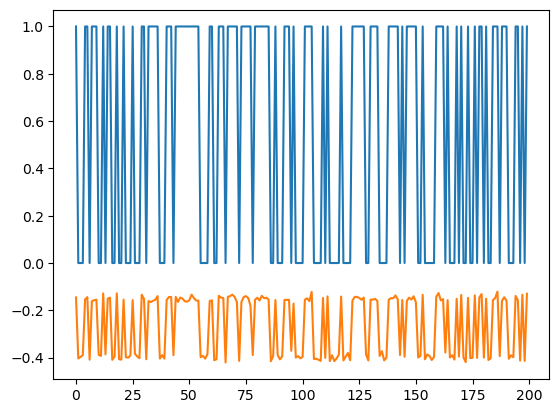

In [3]:
def sim_channel(params, T, dt):
    # kc12, kc21, spikeMax, Fnoise, scale, offset, nSpikes, kco1, koc2, ko12, ko21
    kc12, kc21, Fnoise, scale, offset,  kco1, koc2, ko12, ko21 = params
    
    t = torch.arange(0, T, dt)
    zero = torch.tensor(0.0)
    
    # Convert parameters to tensors
    kc12 = torch.tensor(kc12)
    kc21 = torch.tensor(kc21)
    kco1 = torch.tensor(kco1)
    koc2 = torch.tensor(koc2)
    ko12 = torch.tensor(ko12)
    ko21 = torch.tensor(ko21)
    Fnoise = torch.tensor(Fnoise)
    """
    nSpikes = torch.tensor(nSpikes, dtype=torch.int32)
    spikeMax = torch.tensor(spikeMax)"""
    scale = torch.tensor(scale)

    row1 = torch.stack([zero, kc12, zero, zero])
    row2 = torch.stack([kc21, zero, kco1, zero])
    row3 = torch.stack([zero, koc2, zero, ko12])
    row4 = torch.stack([zero,zero,ko21,zero])
    
    
    r1 = torch.sum(row1)
    #row1 = torch.stack([1-r1, kc12, zero, zero])
    r2 = torch.sum(row2)
    #row2 = torch.stack([kc21, 1-r2, kco1, zero])
    r3 = torch.sum(row3)
    #row3 = torch.stack([zero, koc2, 1-r3, ko12])
    r4 = torch.sum(row4)
    #row4 = torch.stack([zero, zero, ko21, 1-r4])

    def softmax_row(row):
        return torch.nn.functional.softmax(row, dim=0)
    
    row1 = softmax_row(torch.stack([1-r1, kc12, zero, zero]))
    row2 = softmax_row(torch.stack([kc21, 1-r2, kco1, zero]))
    row3 = softmax_row(torch.stack([zero, koc2, 1-r3, ko12]))
    row4 = softmax_row(torch.stack([zero, zero, ko21, 1-r4]))
    transition_matrix = torch.stack([row1, row2, row3, row4])
    
    # Define the transition function
    def transition_fn(state):
        probs = transition_matrix[state]
        return torch.distributions.Categorical(probs=probs).sample()
    
    # Define the initial state distribution
    initial_probs = torch.tensor([0.3, 0.3, 0.2, 0.2])
    initial_distribution = torch.distributions.Categorical(probs=initial_probs)
    
    # Define the Markov chain
    states = [initial_distribution.sample().item()]
    
    for _ in range(T - 1):
        states.append(transition_fn(states[-1]).item())
    
    channels = torch.tensor(states)
    channels = torch.where(channels < 2, torch.zeros_like(channels), torch.ones_like(channels))
    noise = torch.normal(zero, Fnoise, (SIZE,))
    #F = torch.sin(2 * np.pi * t)*Fnoise
    #noise =  A + F 
    return torch.stack([channels, channels * scale + offset + noise], axis=-1)



# Example usage
kc12=0.1
kc21=0.2
Fnoise=0.01
scale=0.25
offset=-0.4
kco1=0.5
koc=0.25
ko12=0.1
ko21=0.2 
orig_params = [0.1, 0.2, 0.01, 0.25, -0.4,  0.5, 0.25, 0.1, 0.2]

channels = sim_channel(orig_params, T, dt)
plt.plot(channels)

In [4]:
# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * (SIZE // 4), 1)
        )

    def forward(self, x):
        return self.model(x.permute(0, 2, 1))

In [5]:
# Loss function for the discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output))
    fake_loss = nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

In [6]:
# Create and compile the discriminator
discriminator = Discriminator()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [7]:
real_data = torch.stack([sim_channel(orig_params, T, dt) for _ in range(NUM_SAMPLES)], dim=0)

In [8]:
def pymc_sim_channel(params, T, dt):
    kc12, kc21, Fnoise, scale, offset, kco1, koc2, ko12, ko21 = params
    
    t = tt.arange(0, T, dt)
    zero = torch.tensor(0.0)
    """
    # Convert parameters to NumPy arrays first
    kc12 = pm.draw(kc12)
    kc21 = pm.draw(kc21)
    kco1 = pm.draw(kco1)
    koc2 = pm.draw(koc2)
    ko12 = pm.draw(ko12)
    ko21 = pm.draw(ko21)
    #Current version not even using spikes
    nSpikes = pm.draw(nSpikes)
    spikeMax = pm.draw(spikeMax)
    Fnoise = pm.draw(Fnoise)
    scale = pm.draw(scale)
    offset = pm.draw(offset)"""
    
    # Then convert to PyTorch tensors
    kc12 = torch.tensor(kc12)
    kc21 = torch.tensor(kc21)
    kco1 = torch.tensor(kco1)
    koc2 = torch.tensor(koc2)
    ko12 = torch.tensor(ko12)
    ko21 = torch.tensor(ko21)
    """
    nSpikes = torch.tensor(nSpikes, dtype=torch.int32)
    spikeMax = torch.tensor(spikeMax)"""
    Fnoise=torch.tensor(Fnoise)
    scale = torch.tensor(scale)
    offset = torch.tensor(offset)
    
    
    row1 = torch.stack([zero, kc12, zero, zero])
    row2 = torch.stack([kc21, zero, kco1, zero])
    row3 = torch.stack([zero, koc2, zero, ko12])
    row4 = torch.stack([zero, zero, ko21, zero])
    
    r1 = torch.sum(row1)
    #row1 = torch.stack([1-r1, kc12, zero, zero])
    r2 = torch.sum(row2)
    #row2 = torch.stack([kc21, 1-r2, kco1, zero])
    r3 = torch.sum(row3)
    #row3 = torch.stack([zero, koc2, 1-r3, ko12])
    r4 = torch.sum(row4)
    #row4 = torch.stack([zero, zero, ko21, 1-r4])

    def softmax_row(row):
        return torch.nn.functional.softmax(row, dim=0)
    
    row1 = softmax_row(torch.stack([1-r1, kc12, zero, zero]))
    row2 = softmax_row(torch.stack([kc21, 1-r2, kco1, zero]))
    row3 = softmax_row(torch.stack([zero, koc2, 1-r3, ko12]))
    row4 = softmax_row(torch.stack([zero, zero, ko21, 1-r4]))
            
    transition_matrix = torch.stack([row1, row2, row3, row4])
    
    def transition_fn(state):
        probs = transition_matrix[state]
        return torch.distributions.Categorical(probs=probs).sample()
    
    initial_probs = torch.tensor([0.3, 0.3, 0.2, 0.2])
    initial_distribution = torch.distributions.Categorical(probs=initial_probs)
    
    states = [initial_distribution.sample().item()]
    
    for _ in range(T - 1):
        states.append(transition_fn(states[-1]).item())
    
    channels = torch.tensor(states)
    channels = torch.where(channels < 2, torch.zeros_like(channels), torch.ones_like(channels))
    noise = torch.normal(zero, Fnoise, (SIZE,))
    
    res =  torch.stack([channels, channels * scale + offset + noise], axis=-1)
    return res.numpy() 


In [9]:
# Define the Bayesian model
with pm.Model() as model:
    # Priors for parameters
    # kc12, kc21, spikeMax, Fnoise, scale, offset, nSpikes, kco1, koc2, ko12, ko21
    kc21 = pm.Beta('kc21', alpha=2, beta=5)
    kc12 = pm.Beta('kc12', alpha=2, beta=5)
    kco1 = pm.Beta('kco1', alpha=2, beta=5)
    koc2 = pm.Beta('koc2', alpha=2, beta=5)
    ko12 = pm.Beta('ko12', alpha=2, beta=5)
    ko21 = pm.Beta('ko21', alpha=2, beta=5)
    """
    nSpikes = pm.HalfNormal('nSpikes', sigma=0.1)
    spikeMax = pm.HalfNormal('spikeMax', sigma=0.1)"""
    Fnoise = pm.HalfNormal('Fnoise', sigma=1)
    scale = pm.HalfNormal('scale', sigma=1)
    offset = pm.Normal('offset', mu=0, sigma=1)
    """  
    synthetic_data = pm.Deterministic('synthetic_data', 
                                      pymc_sim_channel([kc12, kc21, spikeMax, Fnoise, scale, offset, nSpikes, kco1, koc2, ko12, ko21], T, dt))
    """
    
    # Placeholder for discriminator feedback (will be updated during training)
    discriminator_output = pm.MutableData('discriminator_output', value=0)

    # Likelihood (we want the discriminator to output close to 1 for generated data)
    pm.Normal('likelihood', mu=discriminator_output, sigma=0.1, observed=1)

In [10]:
# Training loop
for epoch in tqdm(range(EPOCHS)):
    if epoch > 0:
        summary = az.summary(trace)
        print(summary)
        print(disc_loss)
    # Sample from the posterior
    with model:
        trace = pm.sample(5000, tune=500, chains=8, cores=8)
    
    # Generate synthetic data using the samples
    synthetic_data = []
    for i in range(NUM_SAMPLES):
        idx = np.random.randint(len(trace))
        
        posterior = trace.posterior.stack(sample=['chain', 'draw']) 
        #Concerned order might not be correct so manually doing this
        #params = [trace.get_values(param)[idx] for param in model.named_vars.keys() if param != 'likelihood']
        # kc12, kc21, spikeMax, Fnoise, scale, offset, nSpikes, kco1, koc2, ko12, ko21
        
        """ikc12 = posterior['kc12'][idx].values
        ikc21 = posterior['kc21'][idx].values
        ikco1 = posterior['kco1'][idx].values
        ikoc2 = posterior['koc2'][idx].values
        iko12 = posterior['ko12'][idx].values
        iko21 = posterior['ko21'][idx].values
        iFnoise = posterior['Fnoise'][idx].values
        iscale = posterior['scale'][idx].values
        ioffset = posterior['offset'][idx].values"""
        ikc12 = posterior['kc12'].mean().values
        ikc21 = posterior['kc21'].mean().values
        ikco1 = posterior['kco1'].mean().values
        ikoc2 = posterior['koc2'].mean().values
        iko12 = posterior['ko12'].mean().values
        iko21 = posterior['ko21'].mean().values
        iFnoise = posterior['Fnoise'].mean().values
        iscale = posterior['scale'].mean().values
        ioffset = posterior['offset'].mean().values  
        """
        inSpikes = posterior['nSpikes'][idx].values
        ispikeMax = posterior['spikeMax'][idx].values"""
        
        #kc12, kc21, spikeMax, Fnoise, scale, offset, nSpikes, kco1, koc2, ko12, ko21 = params
        params = [ikc12, ikc21, iFnoise, iscale, ioffset, ikco1, ikoc2, iko12, iko21]
        strip = pymc_sim_channel(params, T, dt)
        #synthetic_data.append(strip.clone().detach().to(dtype=torch.float32))
        synthetic_data.append(torch.from_numpy(strip).float())
    synthetic_data = torch.stack(synthetic_data)
    
    # Train discriminator
    for _ in range(5):  # Train discriminator more than generator
        real_output = discriminator(real_data)
        fake_output = discriminator(synthetic_data)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        
        discriminator_optimizer.zero_grad()
        disc_loss.backward()
        discriminator_optimizer.step()

    # Update the model's posterior using the discriminator's feedback
    with model:
        pm.set_data({'discriminator_output': fake_output.mean().item()})
    clear_output(wait=True)

  1%|█▏                                                                                                                 | 1/100 [00:12<20:58, 12.71s/it]

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
offset  0.003  0.997  -1.799    1.949      0.005    0.005   45815.0   29006.0   
kc21    0.286  0.160   0.020    0.576      0.001    0.001   45480.0   22625.0   
kc12    0.286  0.160   0.023    0.580      0.001    0.001   44758.0   23069.0   
kco1    0.287  0.159   0.020    0.573      0.001    0.001   44330.0   24732.0   
koc2    0.286  0.160   0.023    0.578      0.001    0.001   46077.0   23971.0   
ko12    0.286  0.161   0.020    0.575      0.001    0.001   44076.0   23651.0   
ko21    0.286  0.160   0.020    0.573      0.001    0.001   45907.0   22459.0   
Fnoise  0.791  0.603   0.000    1.876      0.003    0.002   21670.0   12534.0   
scale   0.801  0.605   0.000    1.895      0.003    0.002   27394.0   15342.0   

        r_hat  
offset    1.0  
kc21      1.0  
kc12      1.0  
kco1      1.0  
koc2      1.0  
ko12      1.0  
ko21      1.0  
Fnoise    1.0  
scale     1.0  
tensor(1.2968, grad_fn=<AddBa

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]


Sampling 7 chains for 500 tune and 1_041 draw iterations (3_500 + 7_287 draws total) took 1 seconds.
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10763f400>>
Traceback (most recent call last):
  File "/Users/rbj/miniconda3/envs/metal_102/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  1%|█▏                                                                                                                 | 1/100 [00:19<31:40, 19.20s/it]

KeyboardInterrupt



In [ ]:
# Final evaluation
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)
az.plot_trace(trace)

In [ ]:
summary = az.summary(trace)
print(summary)

In [ ]:
# Extracting parameter names
parameter_names = summary.index.tolist()

# Iterating through parameter names
params=[]
for i, param in enumerate(parameter_names):
    mean_value = summary.loc[param, 'mean']
    params.append(mean_value)
    print(f"Parameter: {param}, Mean: {mean_value}")
    if i >= 5:
        break

In [ ]:
plt.plot(sim_channel([params[1],params[2],params[3],params[4],params[5],params[0]],T,dt))
plt.show()